# UNHAS: Monitoring chlorophyll-<i>a</i> in Lake Tempe

<!-- <i><font color='red'>Notebook & repo</font></i> -->

**Contents**

 - [Overview](#Overview)
   - [Sentinel-2 use case](#Sentinel-2-use-case)
   - [Description](#Description)
 - [Notebook setup](#Notebook-setup)
   - [Dask](#Dask)
 - [Region of interest](#Region-of-interest)
   - [Analysis parameters](#Analysis-parameters)
   - [Selected location display](#Selected-location-display)
 - [Sentinel-2 dataset](#Sentinel-2-dataset)
   - [Interrogating the DC database](#Interrogating-the-DC-database)
   - [Loading the data](#Loading-the-data)
   - [Cleaning up the data](#Cleaning-up-the-data)
   - [Visualise the data](#Visualise-the-data)
 - [Masking the raster data with a shapefile](#Masking-the-raster-data-with-a-shapefile)
   - [Loading up the shapefile](#Loading-up-the-shapefile)
   - [Creating a raster mask](#Creating-a-raster-mask)
   - [Applying the mask to the data time series](#Applying-the-mask-to-the-data-time-series)
 - [Band indices](#Band-indices)
   - [Band arithmetic](#Band-arithmetic)
   - [Computation](#Computation)
 - [Summary plot](#Summary-plot)
   - [Analysis constants](#Analysis-constants)
   - [Total water area](#Total-water-area)
   - [Average NDCI](#Average-NDCI)
   - [Combined indices plot](#Combined-indices-plot)
 - [Spatial plots](#Spatial-plots)
   - [NDCI plots](#NDCI-plots)
   - [True colour display](#True-colour-display)

# Overview

Inland waterbodies are essential for supporting human life, both through the supply of drinking water and the support of agriculture and aquaculture.
Such waterbodies can be contaminated by outbreaks of blue-green (and other toxic) algae, causing health issues for people and animals.
For example, up to a million fish died during an [algal bloom event](https://www.abc.net.au/news/2019-01-08/second-fish-kill-in-darling-river-at-menindee/10696632) in the Darling river in late 2018 and early 2019. 
While the health of waterbodies can be monitored from the ground through sampling, satellite imagery can complement this, potentially improving the detection of large algal bloom events.
However, there needs to be a well-understood and tested way to link satellite observations to the presence of algal blooms.

## Sentinel-2 use case

<!-- <i><font color='red'>NDCI and NDWI</font></i> -->

Algal blooms are associated with the presence of clorophyll-*a* in waterbodies.
[Mishra and Mishra (2012)](https://doi.org/10.1016/j.rse.2011.10.016) developed the normalised difference chlorophyll index (NDCI), which serves as a qualitative indicator for the concentration of chlorophyll-*a* on the surface of a waterbody.
The index requires information from a specific part of the infrared specturm, known as the 'red edge'. 
This is captured as part of Sentinel-2's spectral bands, making it possible to measure the NDCI with Sentinel-2. 

On the other hand, the following caveats should also be kept in mind:

* The NDCI is currently treated as an experimental index for Australia, as futher work is needed to calibrate and validate how well the index relates to the presence of chlorophyll-*a*. 
* It is also important to remember that algal blooms will usually result in increased values of the NDCI, but not all NDCI increases will be from algal blooms. For example, there may be seasonal fluctuations in the amount of chlorophyll-*a* in a waterbody.
* Further validation work is required to understand how shallow water and atmospheric effects affect the NDCI, and its use in identifying high concentrations of chlorophyll-*a*.

## Description

In this example, we measure the NDCI for Lake Tempe, South Sulawesi, Indonesia. This is combined with information about the size of the waterbody, which is used to build a helpful visualisation of how the water level and presence of chlorophyll-*a* changes over time. The worked example takes users through the code required to:

<!-- <i><font color='red'>Overview</font></i> -->

1. Interrogating the EASI / ODC database for products (satellites) and measurements (satellite bands and derived products)
1. Use of Dask for distributed processing of large datasets
1. Load Sentinel-2 images for the area of interest and clean up the imagery (clouds, 'no-data' pixels, etc.)
1. Using a shape file to mask the dataset
1. Compute indices to measure the presence of water and chlorophyll-*a*
1. Generate informative visualisations to identify the presence of chlorophyll-*a*.

This notebook is adapted from a [Digital Earth Australia](https://github.com/GeoscienceAustralia/dea-notebooks) example, and can be found in the following [GitHub](https://github.com/unhas-eo/datacube-notebooks) repository.

# Notebook setup

Here, we load the key Python packages and supporting functions for the subsequent analysis.

> The EASI Tools section comes from https://dev.azure.com/csiro-easi/easi-hub-public/_git/hub-notebooks. Git clone this repository to use these tools.

In [1]:
### System
import sys
import warnings
warnings.filterwarnings("ignore")

### Datacube 
import datacube
from datacube.utils import masking
from odc.algo import enum_to_bool

### Data tools
import numpy as np
import xarray as xr
import geopandas as gpd
import rasterio.features

### Plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

### EASI tools
sys.path.append('/home/jovyan/git_hub_notebook/scripts/')
from app_utils import display_map
import notebook_utils

And let's now connect to the datacube database, which provides functionality for loading and displaying stored Earth observation data:

In [2]:
dc = datacube.Datacube(app="Chlorophyll_monitoring")

## Dask

Rather than loading the Sentinel-2 data into the system memory, this notebook will make use of Dask to load up and process the dataset.

Dask is a Python library for distributed (parallel) processing, which allows us to work on very large array or datacube objects that would otherwise not fit in the memory of any single compute node. Dask relies on the creation of a Dask Gateway (or local) cluster with associated scheduler, which is done in the following cell through the `initialize_dask` helper function.

<!-- <i><font color='red'>Dask cluster and scheduler</font></i> -->


In [3]:
cluster, client = notebook_utils.initialize_dask(workers=2, use_gateway=True, wait=False)
display(cluster if cluster else client)
notebook_utils.localcluster_dashboard(client)

Starting new cluster.


'https://hub.sg-dev.easi-eo.solutions/services/dask-gateway/clusters/easihub.bf9086134a804c8086024d6354236e9a/status'

The `Dashboard` link provided above (`Client` section) can be used to monitor the status of the Dask cluster and associated processing tasks during the execution of various cells in the rest of this notebook.

# Region of interest

## Analysis parameters

The following cell sets the analysis parameters, which define the area of interest and the length of time to conduct the analysis over.

<!-- <i><font color='red'>Large dataset</font></i> -->


In [4]:
### Area of interest (Lake Tempe)
latitude = (-4.03, -4.2)
longitude = (119.87, 120.03)

### Range of dates for the analysis
time = ("2018-01-01", "2022-01-01")

## Selected location display

The next cell will display the selected area on an interactive map. Feel free to zoom in and out to get a better understanding of the area you'll be analysing. Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [5]:
display_map(x=longitude, y=latitude)

# Sentinel-2 dataset

## Interrogating the DC database

We can obtain a summary of the various data products available from the current ODC / EASI database, as follows.

<!-- <i><font color='red'>Products, measurements and explorer</font></i> -->

In [6]:
dc.list_products()

name  \
name                                   
s2_l2a                        s2_l2a   
usgs_aws_ls5c2_sr  usgs_aws_ls5c2_sr   
usgs_aws_ls7c2_sr  usgs_aws_ls7c2_sr   
usgs_aws_ls8c2_sr  usgs_aws_ls8c2_sr   

                                                         description license  \
name                                                                           
s2_l2a             Sentinel-2a and Sentinel-2b imagery, processed...    None   
usgs_aws_ls5c2_sr  Landsat 5 USGS Collection 2 Surface Reflectanc...    None   
usgs_aws_ls7c2_sr  Landsat 7 USGS Collection 2 Surface Reflectanc...    None   
usgs_aws_ls8c2_sr  Landsat 8 USGS Collection 2 Surface Reflectanc...    None   

                  default_crs default_resolution  
name                                              
s2_l2a                   None               None  
usgs_aws_ls5c2_sr        None               None  
usgs_aws_ls7c2_sr        None               None  
usgs_aws_ls8c2_sr        None               None

Another way to investigate the available datasets is through the [ODC Explorer](https://explorer.sg-dev.easi-eo.solutions/products/s2_l2a/extents) interface for the current EASI deployment.

In this notebook, we will make use of the dataset of Sentinel-2 imagery, labelled `s2_l2a`. We can further interrogate the specific bands (measurements) available within this product:

In [7]:
product_measurements = dc.list_measurements().loc["s2_l2a"]
product_measurements

name   dtype units  nodata                       aliases  \
measurement                                                            
B01          B01  uint16     1       0    [band_01, coastal_aerosol]   
B02          B02  uint16     1       0               [band_02, blue]   
B03          B03  uint16     1       0              [band_03, green]   
B04          B04  uint16     1       0                [band_04, red]   
B05          B05  uint16     1       0         [band_05, red_edge_1]   
B06          B06  uint16     1       0         [band_06, red_edge_2]   
B07          B07  uint16     1       0         [band_07, red_edge_3]   
B08          B08  uint16     1       0         [band_08, nir, nir_1]   
B8A          B8A  uint16     1       0  [band_8a, nir_narrow, nir_2]   
B09          B09  uint16     1       0       [band_09, water_vapour]   
B11          B11  uint16     1       0    [band_11, swir_1, swir_16]   
B12          B12  uint16     1       0    [band_12, swir_2, swir_22]   
SCL          SCL   uint8     1       0                    [mask, qa]   
AOT          AOT  uint16     1       0   [aerosol_optical_thickness]   
WVP          WVP  uint16     1       0  [scene_average_water_vapour]   

                                              flags_definition  
measurement                                                     
B01                                                        NaN  
B02                                                        NaN  
B03                                                        NaN  
B04                                                        NaN  
B05                                                        NaN  
B06                                                        NaN  
B07                                                        NaN  
B08                                                        NaN  
B8A                                                        NaN  
B09                                                        NaN  
B11                                                        NaN  
B12                                                        NaN  
SCL          {'qa': {'bits': [0, 1, 2, 3, 4, 5, 6, 7], 'val...  
AOT                                                        NaN  
WVP                                                        NaN

Further below, we will mask the data to identify the pixels containing valid information (i.e. not `no-data`), as well as those pixels not affected by clouds, cloud shadow, etc. (i.e. clear pixels). Information regarding the quality of each pixel is provided in the `SCL` data layer (with `mask` or `qa` aliases), which can be investigated in more detail as follows.

In [8]:
product_measurements.loc['SCL']['flags_definition']

{'qa': {'bits': [0, 1, 2, 3, 4, 5, 6, 7],
  'values': {'0': 'no data',
   '1': 'saturated or defective',
   '2': 'dark area pixels',
   '3': 'cloud shadows',
   '4': 'vegetation',
   '5': 'bare soils',
   '6': 'water',
   '7': 'unclassified',
   '8': 'cloud medium probability',
   '9': 'cloud high probability',
   '10': 'thin cirrus',
   '11': 'snow or ice'},
  'description': 'Sen2Cor Scene Classification'}}

## Loading the data

The first step in the analysis is to load Sentinel-2 data for the specified area of interest and time range. We also specifically select various spectral bands to load: the `red`, `green` and `blue` bands will allow for true-colour displays of the Sentinel-2 data, while other bands will be used for the calculation of water-related indices further below. In addition, the pixel QA band `fmask` will be used to mask out the pixels affected by clounds, shadows, etc.

In [9]:
### Datacube load query
query = { "product": "s2_l2a",
          "x": longitude,
          "y": latitude,
          "time": time,
          "measurements": [ "red_edge_1",  # Red edge 1 band
                            "red",         # Red band
                            "green",       # Green band
                            "blue",        # Blue band
                            "swir_2",      # Short-wave infrared band
                            "mask" ],           # Pixel QA band
        }

Sentinel-2 datasets are stored with different coordinate reference systems (CRS), corresponding to multiple UTM zones used for S2 L1B tiling. S2 measurement bands also have different resolutions (10 m, 20 m and 60 m). As such S2 queries need to include the following two query parameters:

- `output_crs` - This sets a consistent CRS that all Sentinel-2 data will be reprojected to, irrespective of the UTM zone the individual image is stored in.
- `resolution` - This sets the resolution that all Sentinel-2 images will be resampled to.

Use `mostcommon_crs()` to select a CRS. Adapted from https://github.com/GeoscienceAustralia/dea-notebooks/blob/develop/Tools/dea_tools/datahandling.py

In [10]:
# Which is the most common native CRS
native_crs = notebook_utils.mostcommon_crs(dc, query)
display(f'Native CRS: {native_crs}')

query.update({
    "output_crs": native_crs,
    "resolution": (-20, 20),
    "dask_chunks": {"y":2048, "x":2048},
})

'Native CRS: epsg:32750'

<!-- <i><font color='red'>Datacube load into Dask arrays</font></i> -->

In [35]:
ds_s2 = dc.load(**query)
ds_s2

<xarray.Dataset>
Dimensions:      (time: 261, y: 945, x: 894)
Coordinates:
  * time         (time) datetime64[ns] 2018-02-09T02:26:33 ... 2021-11-10T02:...
  * y            (y) float64 9.554e+06 9.554e+06 ... 9.535e+06 9.535e+06
  * x            (x) float64 8.186e+05 8.186e+05 ... 8.365e+05 8.365e+05
    spatial_ref  int32 32750
Data variables:
    red_edge_1   (time, y, x) uint16 dask.array<chunksize=(1, 945, 894), meta=np.ndarray>
    red          (time, y, x) uint16 dask.array<chunksize=(1, 945, 894), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 945, 894), meta=np.ndarray>
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 945, 894), meta=np.ndarray>
    swir_2       (time, y, x) uint16 dask.array<chunksize=(1, 945, 894), meta=np.ndarray>
    mask         (time, y, x) uint8 dask.array<chunksize=(1, 945, 894), meta=np.ndarray>
Attributes:
    crs:           epsg:32750
    grid_mapping:  spatial_ref

## Cleaning up the data

Next, we will mask out any clouds (and other pixel QA issues) in the dataset, and also filter out any image where less than 70% of the pixels are classified as clear observations. Note here that we're including `snow` pixels in the dataset of "good" pixels &ndash; quite a few pixels in the time series are identified as being `snow`, but snow cover is highly improbable at the selected location. Instead, these `snow` pixels are very likely to actually represent clear observations that are mis-classified, which is likely to occur in salt lake regions with highly reflective land covers. Rather than removing these likely mis-classified pixels, we thus include them in the set of clear observations.

<!-- <i><font color='red'>Removing invalid and low-quality pixels, low-quality images</font></i> -->


In [36]:
min_gooddata = 0.6   # percentage threshold

### Mask of valid pixels
good_pixel_flags = {'bare soils','water','vegetation',                   # pixels to retain (i.e. remove pixels flagged as 'no data','saturated or defective',
                    'snow or ice','dark area pixels','unclassified'}     # 'cloud shadows','cloud medium probability','cloud high probability','thin cirrus')

good_pixel_mask = enum_to_bool(ds_s2['mask'], good_pixel_flags)
good_pixel_mask = good_pixel_mask.persist()

### Percentage of good data for each time slice
data_perc = good_pixel_mask.sum(axis=[1,2]) / (good_pixel_mask.shape[1]*good_pixel_mask.shape[2])
keep = (data_perc>=min_gooddata).persist()

### Drop low quality time slices
total_obs = len(ds_s2.time)
ds_s2 = ds_s2.sel(time=keep)
good_pixel_mask = good_pixel_mask.sel(time=keep)

print(f'Filtered the time series to {len(ds_s2.time)} (out of {total_obs}) '
      f'time steps with at least {min_gooddata:.1%} good quality pixels.')

Filtered the time series to 96 (out of 261) time steps with at least 60.0% good quality pixels.


Finally, we can apply the resulting 'good pixel' mask to the data, as well as a further 'no-data' mask and further scaling operations.

In [37]:
### Valid mask (i.e. not 'nodata'), for each data layer
valid_mask = masking.valid_data_mask(ds_s2)

### Scaling factors for Sentinel-2 data (GA S2 products)
scale = 0.0001  # divide by 10000
offset = 0.0

### Apply valid mask, good pixel mask, and scaling to each layer
ds_s2['red_edge_1'] = ds_s2['red_edge_1'].where(valid_mask['red_edge_1'] & good_pixel_mask) * scale + offset
ds_s2['red'] =        ds_s2['red'].where(valid_mask['red'] & good_pixel_mask)               * scale + offset
ds_s2['green'] =      ds_s2['green'].where(valid_mask['green'] & good_pixel_mask)           * scale + offset
ds_s2['blue'] =       ds_s2['blue'].where(valid_mask['blue'] & good_pixel_mask)             * scale + offset
ds_s2['swir_2'] =     ds_s2['swir_2'].where(valid_mask['swir_2'] & good_pixel_mask)         * scale + offset
ds_s2 = ds_s2.persist()

Once the processing is complete, we can examine the data as done in the next cell. The `Dimensions` argument reveals the number of time steps in the dataset, as well as the number of pixels in the `x` (longitude) and `y` (latitude) dimensions. Clicking on the `data repr` icon for each of the `Data variables` also confirms that the data is currently loaded as Dask chunks on the Dask cluster.

In [14]:
ds_s2

<xarray.Dataset>
Dimensions:      (time: 96, y: 945, x: 894)
Coordinates:
  * time         (time) datetime64[ns] 2018-02-09T02:26:33 ... 2021-10-31T02:...
  * y            (y) float64 9.554e+06 9.554e+06 ... 9.535e+06 9.535e+06
  * x            (x) float64 8.186e+05 8.186e+05 ... 8.365e+05 8.365e+05
    spatial_ref  int32 32750
Data variables:
    red_edge_1   (time, y, x) float64 dask.array<chunksize=(1, 945, 894), meta=np.ndarray>
    red          (time, y, x) float64 dask.array<chunksize=(1, 945, 894), meta=np.ndarray>
    green        (time, y, x) float64 dask.array<chunksize=(1, 945, 894), meta=np.ndarray>
    blue         (time, y, x) float64 dask.array<chunksize=(1, 945, 894), meta=np.ndarray>
    swir_2       (time, y, x) float64 dask.array<chunksize=(1, 945, 894), meta=np.ndarray>
    mask         (time, y, x) uint8 dask.array<chunksize=(1, 945, 894), meta=np.ndarray>
Attributes:
    crs:           epsg:32750
    grid_mapping:  spatial_ref

## Visualise the data

We can visualise the data using a true-colour image display for a number of time steps. White areas indicate where clouds or other invalid pixels in the image have been masked.

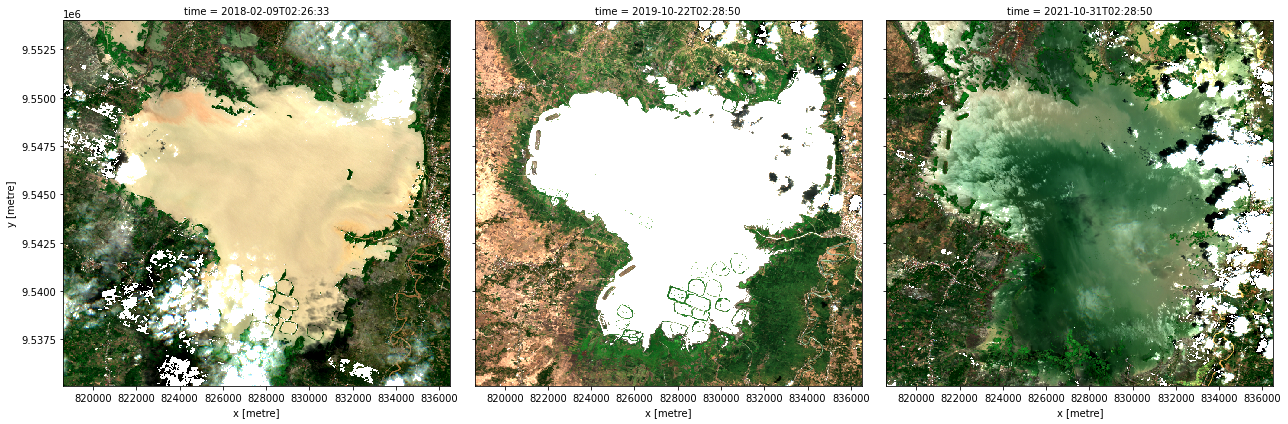

In [15]:
tmp = np.linspace(1, ds_s2.sizes['time'], 3, dtype='int') - 1   # select some time slices to display

### Plot the selected time slices (true-colour display)
image_array = ds_s2[['red', 'green', 'blue']].isel(time=tmp).to_array()
image_array.plot.imshow(robust=True, col='time', col_wrap=3, size=6, aspect=ds_s2.x.shape[0]/ds_s2.y.shape[0]);

# Masking the raster data with a shapefile

## Loading up the shapefile

For this example, we use a polygon of Lake Tempe's boundary, which is provided in the `ancillary_data` folder in this repository.

In [16]:
# shape_file = './ancillary_data/Base Map/Boundary_CA_TempeLake_AR.shp'
shape_file = './ancillary_data/Base Map/Boundary_administration.shp'

### Load the shapefile
shp = gpd.read_file(shape_file)
display(shp)
shp.crs

Zona          Province            Regency          District  \
0    Zona 50S  SULAWESI SELATAN  SIDENRENG RAPPANG  WATANG SIDENRENG   
1    Zona 50S  SULAWESI SELATAN  SIDENRENG RAPPANG  WATANG SIDENRENG   
2    Zona 50S  SULAWESI SELATAN  SIDENRENG RAPPANG  WATANG SIDENRENG   
3    Zona 50S  SULAWESI SELATAN  SIDENRENG RAPPANG  WATANG SIDENRENG   
4    Zona 50S  SULAWESI SELATAN  SIDENRENG RAPPANG  WATANG SIDENRENG   
..        ...               ...                ...               ...   
553  Zona 50S  SULAWESI SELATAN               GOWA       TOMBOLO PAO   
554  Zona 51S  SULAWESI SELATAN  SIDENRENG RAPPANG          DUAPITUE   
555  Zona 50S  SULAWESI SELATAN  SIDENRENG RAPPANG          DUAPITUE   
556  Zona 51S  SULAWESI SELATAN  SIDENRENG RAPPANG          DUAPITUE   
557  Zona 50S  SULAWESI SELATAN  SIDENRENG RAPPANG          DUAPITUE   

        Village                                           geometry  
0     SIDENRENG  POLYGON Z ((119.85504 -3.91274 0.00000, 119.85...  
1      AKA-AKAE  POLYGON Z ((119.87492 -3.91134 0.00000, 119.87...  
2       EMPAGAE  POLYGON Z ((119.87786 -3.92084 0.00000, 119.87...  
3       TALUMAE  POLYGON Z ((119.90144 -3.92196 0.00000, 119.89...  
4        MOJONG  POLYGON Z ((119.91333 -3.95609 0.00000, 119.91...  
..          ...                                                ...  
553  ERELEMBANG  MULTIPOLYGON Z (((119.87627 -5.09185 0.00000, ...  
554      KALOSI  POLYGON Z ((120.00922 -3.88076 0.00000, 120.00...  
555      KALOSI  MULTIPOLYGON Z (((120.00000 -3.89772 0.00000, ...  
556     KAMPALE  MULTIPOLYGON Z (((120.00000 -3.90325 0.00000, ...  
557     KAMPALE  MULTIPOLYGON Z (((119.99819 -3.89662 0.00000, ...  

[558 rows x 6 columns]

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

We can see here that the vector data within that shapefile is in the projection `EPSG:4326`, which is different from that of our main Sentinel-2 dataset (`EPSG:32750`). For compatibility, we can here re-project the shapefile data to the CRS of the Sentinel-2 dataset.

In [17]:
### Reproject
shp = shp.to_crs(native_crs)

In [18]:
# np.unique( list(shp.Province) )
# np.unique( list(shp.Regency) )
# np.unique( list(shp.District) )
# np.unique( list(shp.Village) )
# [ii for ii,vv in enumerate(list(shp.Village)) if 'tempe' in vv.lower()]
# [ii for ii,vv in enumerate(list(shp.District)) if 'tempe' in vv.lower()]
# [ii for ii,vv in enumerate(list(shp.Regency)) if 'tempe' in vv.lower()]

The shape file we've just loaded contains a large number of polygons corresponding to the various jurisdictions in South Sulawesi. So let's now select only those polygons corresponding to Lake Tempe:

In [19]:
drop_list = []
for ff in shp.iterrows():
    if 'tempe' in ff[1].Village.lower():
        print(ff[0],ff[1].Village)
    else:
        drop_list.append( ff[0] )
        
shp.drop( drop_list, inplace=True )
shp

88 TEMPE
114 DANAU TEMPE
115 DANAU TEMPE


Zona          Province      Regency     District      Village  \
88   Zona 51S  SULAWESI SELATAN         WAJO        TEMPE        TEMPE   
114  Zona 51S  SULAWESI SELATAN  DANAU TEMPE  DANAU TEMPE  DANAU TEMPE   
115  Zona 50S  SULAWESI SELATAN  DANAU TEMPE  DANAU TEMPE  DANAU TEMPE   

                                              geometry  
88   POLYGON ((836433.832 9543340.933, 836425.231 9...  
114  POLYGON ((835582.554 9549249.702, 835582.022 9...  
115  POLYGON ((830818.759 9551339.065, 830848.271 9...

We can now produce a plot of the polygons of interest from the original shape file.

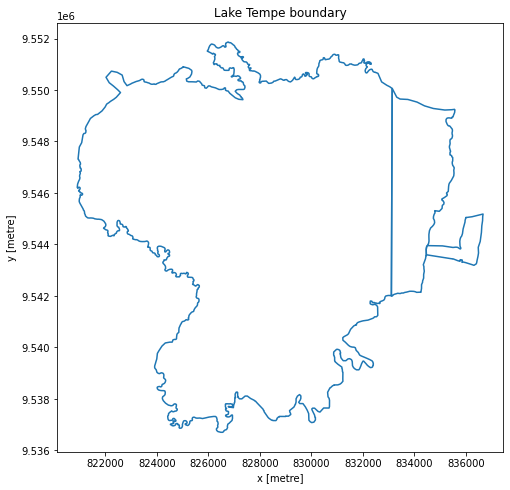

In [20]:
### Plot
shp.boundary.plot(figsize=(8,8))
plt.xlabel("x [metre]"); plt.ylabel("y [metre]")
plt.title("Lake Tempe boundary");

## Creating a raster mask

We can now create a raster mask from the vector data. The code below iterates over the polygons in the shapefile (in case multiple polygons are available), setting the raster mask values to 1 for all the pixels corresponding to the footprint of each polygon.

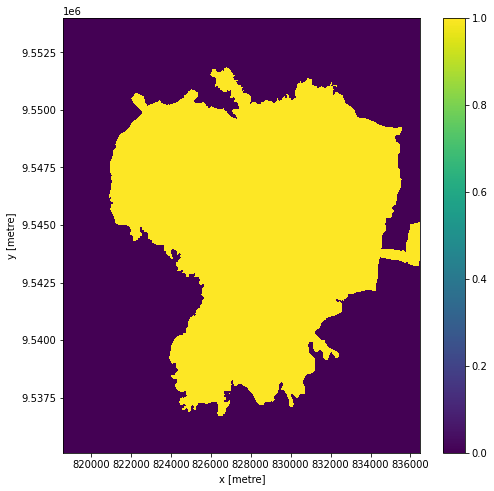

In [21]:
mask = rasterio.features.rasterize( ((feature['geometry'], 1) for feature in shp.iterfeatures()),
                                    out_shape = (ds_s2.dims['y'],ds_s2.dims['x']),
                                    transform = ds_s2.affine )

### Convert the mask (numpy array) to an Xarray DataArray
mask = xr.DataArray(mask, coords=(ds_s2.y, ds_s2.x))

mask.plot(figsize=(8,8));

## Applying the mask to the data time series

Finally, we can use the mask we just created, apply it to the time series of Sentinel-2 data, and plot the result.

In [22]:
### Masking
ds_s2 = ds_s2.where(mask)
ds_s2 = ds_s2.persist()

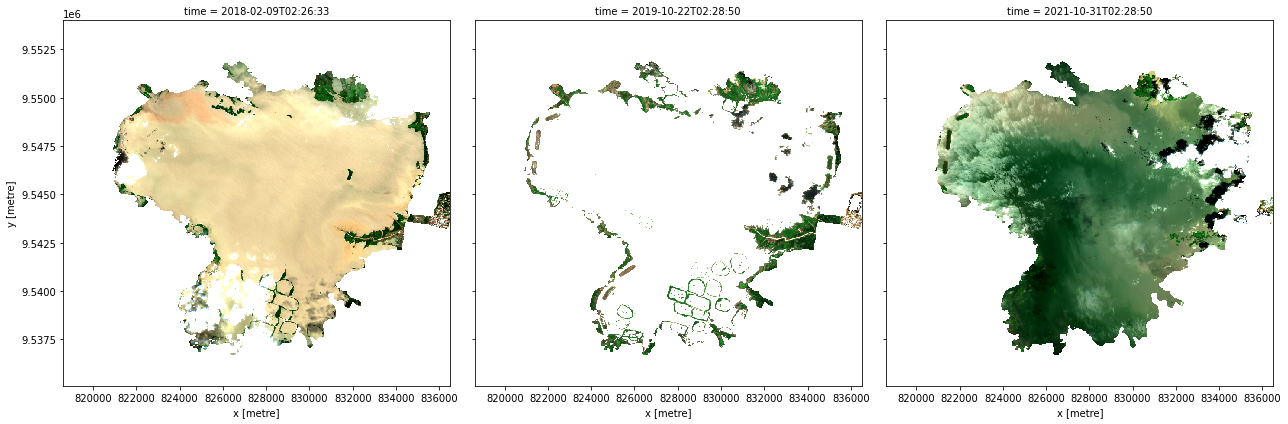

In [23]:
tmp = np.linspace(1, ds_s2.sizes['time'], 3, dtype='int') - 1   # select some time slices to display

### Plot the selected time slices (true-colour display)
image_array = ds_s2[['red', 'green', 'blue']].isel(time=tmp).to_array()
image_array.plot.imshow(robust=True, col='time', col_wrap=3, size=6, aspect=ds_s2.x.shape[0]/ds_s2.y.shape[0]);

# Band indices

## Band arithmetic

This study measures the presence of water through the modified normalised difference water index (MNDWI), while the amount of clorophyll-*a* is calculated using the normalised difference clorophyll index (NDCI).

MNDWI is calculated from the `green` and shortwave infrared (`SWIR`) bands to identify water.
The formula is

$$
\begin{aligned}
\text{MNDWI} = \frac{\text{Green} - \text{SWIR}}{\text{Green} + \text{SWIR}}.
\end{aligned}
$$

When interpreting this index, values greater than 0 indicate water.

NDCI is calculated from the `red edge 1` and `red` bands to identify water.
The formula is

$$
\begin{aligned}
\text{NDCI} = \frac{\text{Red_edge_1} - \text{Red}}{\text{Red_edge_1} + \text{Red}}.
\end{aligned}
$$

When interpreting this index, higher values indicate a higher concentration of clorophyll-*a*.

## Computation

As per the formulae provided above, we can now calculate the relevant indices from the various bands in our dataset. The code below achieves this, and subsequently saves the results back as new layers in the `ds_s2` dataset.

In [24]:
### MNDWI
ds_s2['MNDWI'] = ( (ds_s2.green - ds_s2.swir_2) /
                   (ds_s2.green + ds_s2.swir_2) )

### NDCI
ds_s2['NDCI'] = ( (ds_s2.red_edge_1 - ds_s2.red) /
                  (ds_s2.red_edge_1 + ds_s2.red) )

ds_s2 = ds_s2.persist()

The MNDWI and NDCI values should now appear as data variables, along with the loaded measurements, in the `ds_s2` data set. We can check this by printing the data set below:

In [25]:
ds_s2

<xarray.Dataset>
Dimensions:      (time: 96, y: 945, x: 894)
Coordinates:
  * time         (time) datetime64[ns] 2018-02-09T02:26:33 ... 2021-10-31T02:...
  * y            (y) float64 9.554e+06 9.554e+06 ... 9.535e+06 9.535e+06
  * x            (x) float64 8.186e+05 8.186e+05 ... 8.365e+05 8.365e+05
    spatial_ref  int32 32750
Data variables:
    red_edge_1   (time, y, x) float64 dask.array<chunksize=(1, 945, 894), meta=np.ndarray>
    red          (time, y, x) float64 dask.array<chunksize=(1, 945, 894), meta=np.ndarray>
    green        (time, y, x) float64 dask.array<chunksize=(1, 945, 894), meta=np.ndarray>
    blue         (time, y, x) float64 dask.array<chunksize=(1, 945, 894), meta=np.ndarray>
    swir_2       (time, y, x) float64 dask.array<chunksize=(1, 945, 894), meta=np.ndarray>
    mask         (time, y, x) float64 dask.array<chunksize=(1, 945, 894), meta=np.ndarray>
    MNDWI        (time, y, x) float64 dask.array<chunksize=(1, 945, 894), meta=np.ndarray>
    NDCI         (time, y, x) float64 dask.array<chunksize=(1, 945, 894), meta=np.ndarray>
Attributes:
    crs:           epsg:32750
    grid_mapping:  spatial_ref

# Summary plot

To get an understanding of how the waterbody has changed over time, the following section builds a plot that uses the MNDWI to measure (roughly) the area of the waterbody, along with the NDCI to track how the concentration of clorophyll-*a* is changing over time. This could be used to quickly assess the status of a given waterbody.

## Analysis constants

If the pixel area is known, the number of pixels classified as water (i.e, where MNDWI > 0) can be used as a proxy for the area of the waterbody. The following cell generates the necessary constants for performing this conversion.

In [26]:
pixel_length = query["resolution"][1]   # in metres
m_per_km = 1000   # conversion from metres to kilometres

area_per_pixel = pixel_length**2 / m_per_km**2

## Total water area

The next cell starts by filtering the dataset to only keep the pixels that are classified as water. It then calculates the water area by counting all the MNDWI pixels in the filtered data set, calculating a rolling median &ndash; this helps smooth the results to account for variation from cloud-masking. This median count is then multiplied by the area-per-pixel value to obtain an estimate of the water area over time.

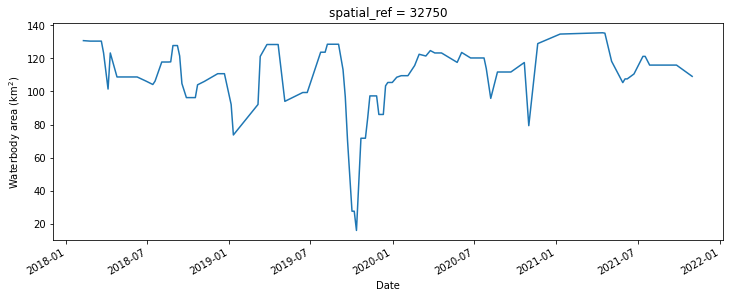

In [27]:
### Water pixels
ds_s2_water = ds_s2.where(ds_s2.MNDWI>0.0)
ds_s2_watercount = ds_s2_water.MNDWI.count(dim=["x", "y"])

### Total water area
waterarea = ds_s2_watercount.rolling(time=3, center=True, min_periods=1).median(skipna=True)
waterarea = waterarea * area_per_pixel
waterarea = waterarea.persist()   # trigger the computation on the Dask workers

### Plot
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
waterarea.plot()
axes.set_xlabel("Date")
axes.set_ylabel("Waterbody area (km$^2$)");

## Average NDCI

The next cell computes the average NDCI for each time step using the filtered data set. This means that we're only tracking the NDCI in waterbody areas, and not on land.

To make the summary plot, we calculate NDCI across all pixels; this allows us to track overall changes in NDCI, but doesn't tell us where the increase occured within the waterbody (this is covered in the next section).

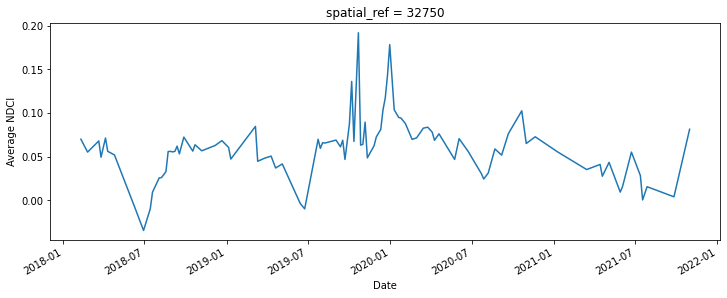

In [28]:
### Average NDCI
average_ndci = ds_s2_water.NDCI.mean(dim=["x", "y"], skipna=True)
average_ndci = average_ndci.persist()   # trigger the computation on the Dask workers

### Plot
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
average_ndci.plot()
axes.set_xlabel("Date")
axes.set_ylabel("Average NDCI");

## Combined indices plot

The cell below combines the total water area and average NDCI time series we generated above into a single summary plot. Notice that Python can be used to build highly-customised plots such as the stripe plot below.

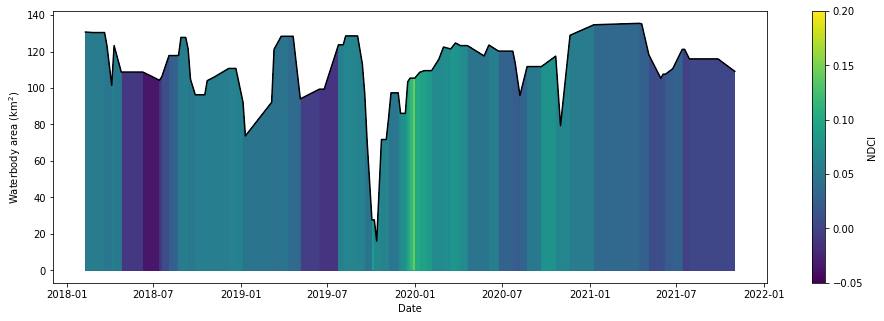

In [29]:
fig, axes = plt.subplots(1, 1, figsize=(16, 5))

### Colour map and normalisation
# NDCI is plotted on a scale of -0.1 to 0.3, so normalise the colour map accordingly
min_ndci_scale = -0.05
max_ndci_scale = 0.2
cmap = plt.get_cmap("viridis")
normal = plt.Normalize(vmin=min_ndci_scale, vmax=max_ndci_scale)

### Store dataset dates as numbers (for ease of plotting)
dates = matplotlib.dates.date2num(ds_s2_water.time.values)

### Waterbody area line
axes.plot_date(x=dates, y=waterarea, color="black", linestyle="-", marker="")

### NDCI as filled stripes
# Fill in the plot by looping over the possible threshold values and filling
# the areas that are greater than the threshold
color_vals = np.linspace(0, 1, 100)
threshold_vals = np.linspace(min_ndci_scale, max_ndci_scale, 100)
for ii,thresh in enumerate(threshold_vals):
    im = axes.fill_between( dates, 0, waterarea, where=(average_ndci>=thresh),
                            norm=normal, facecolor=cmap(color_vals[ii]), alpha=1 )

### Colour bar
cax, _ = matplotlib.colorbar.make_axes(axes)
cb2 = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normal)
cb2.set_label("NDCI")

### Titles and labels
axes.set_xlabel("Date")
axes.set_ylabel("Waterbody area (km$^2$)");

# Spatial plots

## NDCI plots

While the summary plot above is useful at a glance, it can be interesting to see the full spatial picture at times where the NDCI is especially low or high. In the cell below, we first identify the time indices corresponding to the minimum and maximum NDCI values in the time series. We can then use these time indices to extract and plot the data of interest.

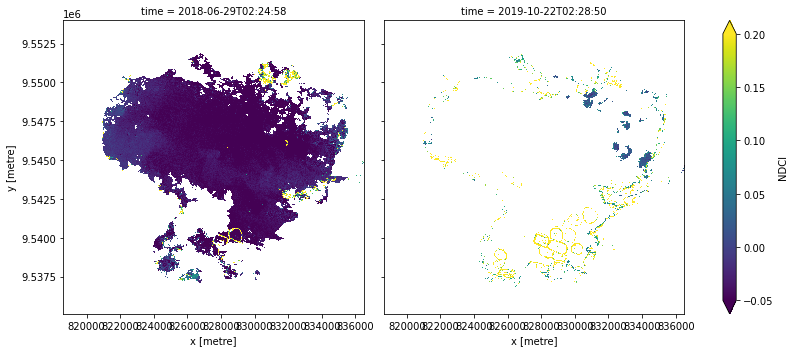

In [30]:
ndci_dates = ds_s2.time.values
min_ndci_date = ndci_dates[ np.nanargmin(average_ndci.values) ]
max_ndci_date = ndci_dates[ np.nanargmax(average_ndci.values) ]

# Selected dates as Xarray data array (to select dates from the dataset)
time_xr = xr.DataArray([min_ndci_date, max_ndci_date], dims=["time"])

### NDCI plots
ds_s2_water.NDCI.sel(time=time_xr).plot.imshow( "x", "y", col="time", cmap=cmap,
                                                vmin=min_ndci_scale, vmax=max_ndci_scale,
                                                col_wrap=2, robust=True, figsize=(12, 5) );

Alternatively, we could also manually select two specific dates to display. The code below defines two useful functions: `closest_date` will find the date in a list of dates closest to any given date, and `date_index` will return the position of a particular date in a list of dates. These functions are useful for selecting images to compare. 

In [31]:
def closest_date(list_of_dates, desired_date):
    return min( list_of_dates, key=lambda x: abs(x-np.datetime64(desired_date)) )

def date_index(list_of_dates, known_date):
    return (np.where(list_of_dates == known_date)[0][0])

Run the cell below to define and plot two dates to compare.

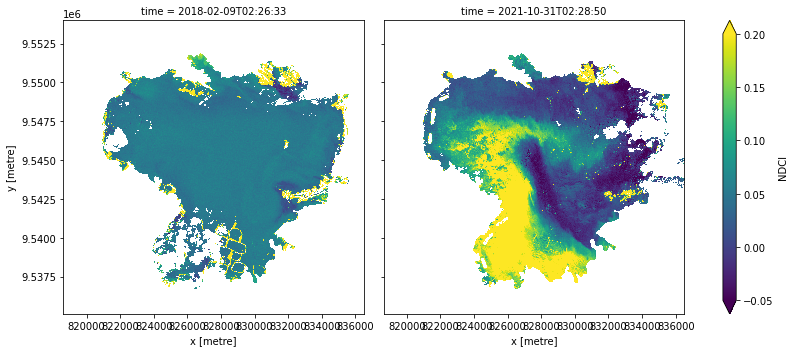

In [32]:
### Dates to view
date_1 = time[0]  # or change to a significant date from plots above, "yyyy-mm-dd"
date_2 = time[1]  # or change to a significant date from plots above, "yyyy-mm-dd"

### Closest date available
closest_date_1 = closest_date(ds_s2.time.values, date_1)
closest_date_2 = closest_date(ds_s2.time.values, date_2)

# Selected dates as Xarray data array (to select dates from the dataset)
time_xr = xr.DataArray([closest_date_1, closest_date_2], dims=["time"])

### NDCI plots
ds_s2_water.NDCI.sel(time=time_xr).plot.imshow( "x", "y", col="time", cmap=cmap,
                                                vmin=min_ndci_scale, vmax=max_ndci_scale,
                                                col_wrap=2, robust=True, figsize=(12, 5) );

## True colour display

And finally, the cell below displays the true-colour images for the selected dates.

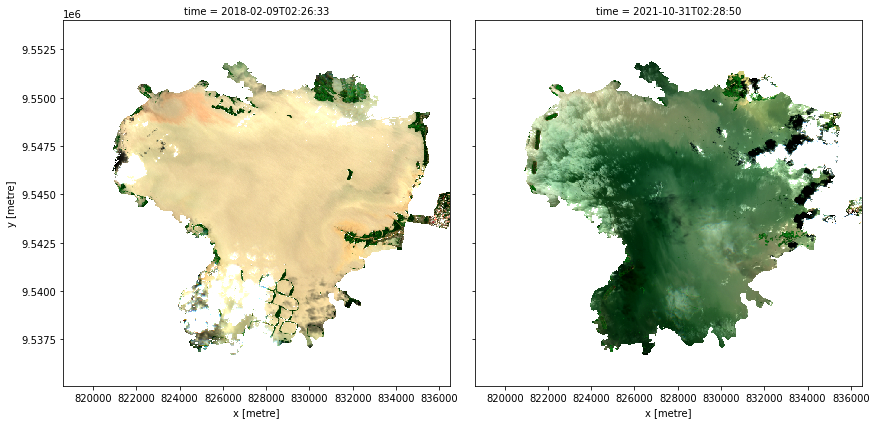

In [33]:
### Index of closest dates
closest_date_1_idx = date_index(ds_s2.time.values, closest_date_1)
closest_date_2_idx = date_index(ds_s2.time.values, closest_date_2)

### True colour plots
image_array = ds_s2[['red', 'green', 'blue']].isel(time=[closest_date_1_idx, closest_date_2_idx]).to_array()
image_array.plot.imshow(robust=True, col='time', col_wrap=3, size=6, aspect=ds_s2.x.shape[0]/ds_s2.y.shape[0]);

In [34]:
### End notebook